In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('first_round_requests/firstround_requests_clean.csv')
df.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,proba,pred,true_class
0,Person and Vehicle search,2022-01-01T03:08:37+00:00,NaN,52.312706,-0.225271,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire,0.715158,True,1.0
1,Person search,2022-01-01T04:29:00+00:00,True,50.625847,-3.546839,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.446089,False,0.0
2,Person search,2022-01-01T05:50:23+00:00,NaN,51.518091,-0.078308,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.127540,False,0.0
3,Person search,2022-01-01T07:34:03+00:00,NaN,51.506255,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.173887,False,0.0
4,Person search,2022-01-01T16:43:00+00:00,False,50.725010,-3.524855,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.462372,False,1.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Type                          4000 non-null   object 
 1   Date                          4000 non-null   object 
 2   Part of a policing operation  2691 non-null   object 
 3   Latitude                      2829 non-null   float64
 4   Longitude                     2829 non-null   float64
 5   Gender                        4000 non-null   object 
 6   Age range                     4000 non-null   object 
 7   Officer-defined ethnicity     4000 non-null   object 
 8   Legislation                   4000 non-null   object 
 9   Object of search              4000 non-null   object 
 10  station                       4000 non-null   object 
 11  proba                         4000 non-null   float64
 12  pred                          4000 non-null   bool   
 13  tru

In [3]:
# evaluate duplicates
print (f"There are {df.duplicated().sum()} duplicated entries in the dataset")

mask_duplicates = df.duplicated()
df_duplicated = df[mask_duplicates]
df_duplicated.head()

There are 43 duplicated entries in the dataset


,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,proba,pred,true_class
131,Person search,2022-01-03T21:00:00+00:00,False,51.919520,-0.436911,Male,18-24,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,bedfordshire,0.622636,True,0.0
199,Person search,2022-01-05T16:00:00+00:00,False,NaN,NaN,Female,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,bedfordshire,0.513703,True,1.0
313,Person and Vehicle search,2022-01-08T00:15:00+00:00,NaN,54.659516,-1.549268,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,durham,0.651960,True,1.0
534,Person and Vehicle search,2022-01-12T12:15:00+00:00,False,NaN,NaN,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,bedfordshire,0.607081,True,1.0
605,Person search,2022-01-13T18:00:00+00:00,NaN,54.775686,-1.505103,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,durham,0.546246,True,1.0


In [4]:
# check missing values
df.isna().sum()

Type                               0
Date                               0
Part of a policing operation    1309
Latitude                        1171
Longitude                       1171
Gender                             0
Age range                          0
Officer-defined ethnicity          0
Legislation                        0
Object of search                   0
station                            0
proba                              0
pred                               0
true_class                         1
dtype: int64

In [5]:
# There's an observation were we weren't able to store the true_class
df[df['true_class'].isnull()]

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,proba,pred,true_class
607,Person search,2022-01-14T00:20:00+00:00,False,51.01583,-4.205606,Female,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,devon-and-cornwall,0.067912,False,NaN


In [6]:
df['true_class'].value_counts(dropna=False)

0.0    3125
1.0     874
NaN       1
Name: true_class, dtype: int64

In [7]:
# Drop the observation where true_class is NaN
df = df[df['true_class'].notna()]
df['true_class'].value_counts(dropna=False)

0.0    3125
1.0     874
Name: true_class, dtype: int64

### MODEL EVALUATION  ON NEW REQUESTS

In [8]:
y_test = df['true_class']
preds = df['pred']

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.5553888472118029
F1 Score: 0.382638888888889
Precision: 0.2746759720837488
Recall: 0.6304347826086957


AUC-ROC: 0.5824173913043479


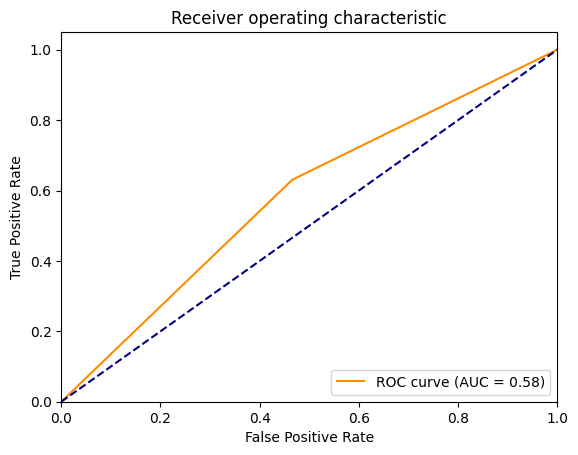

In [25]:
# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, preds)
print('AUC-ROC:', auc_roc)

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, preds)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[1670 1455]
 [ 323  551]]


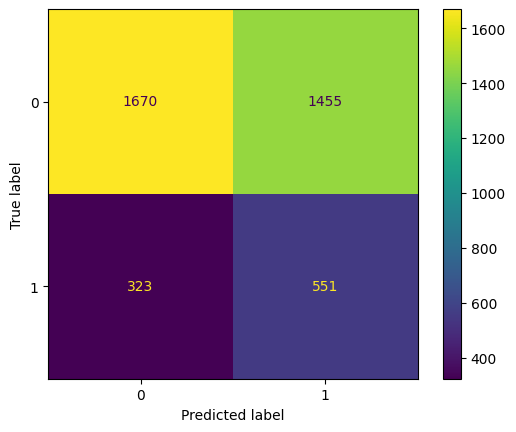

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot confusion matrix
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

### DESCRIPTION OF NEW DATA

- Create successful_searches column again
- Clean up some columns with NaNs

In [27]:
new_df = df.copy()
new_df['Date'] = pd.to_datetime(new_df['Date'])

In [28]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   Type                          3999 non-null   object             
 1   Date                          3999 non-null   datetime64[ns, UTC]
 2   Part of a policing operation  2690 non-null   object             
 3   Latitude                      2828 non-null   float64            
 4   Longitude                     2828 non-null   float64            
 5   Gender                        3999 non-null   object             
 6   Age range                     3999 non-null   object             
 7   Officer-defined ethnicity     3999 non-null   object             
 8   Legislation                   3999 non-null   object             
 9   Object of search              3999 non-null   object             
 10  station                       3999 n

#### Type

In [29]:
# check the types of search operations
new_df['Type'].value_counts(dropna=False)

Person search                3180
Person and Vehicle search     819
Name: Type, dtype: int64

In [30]:
# check the types of search operations (normalized)
new_df['Type'].value_counts(dropna=False,normalize=True)

Person search                0.795199
Person and Vehicle search    0.204801
Name: Type, dtype: float64

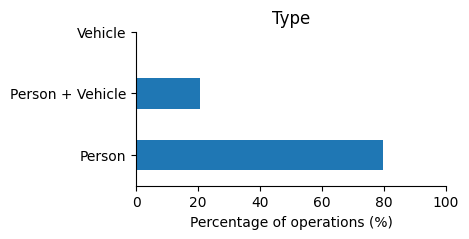

In [31]:
# Plot horizontal bar-plot of "Type" feature
plt.figure(figsize=(4,2))
plt.title('Type')
plt.xlabel('Percentage of operations (%)')
new_df['Type'].value_counts(normalize=True).plot(kind='barh')
plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
plt.yticks([0,1,2],['Person','Person + Vehicle', 'Vehicle'])
sns.despine()

#### Date

In [32]:
# check range of dates in the dataset
print (new_df['Date'].min())
print (new_df['Date'].max())

2022-01-01 00:35:00+00:00
2022-03-14 14:45:00+00:00


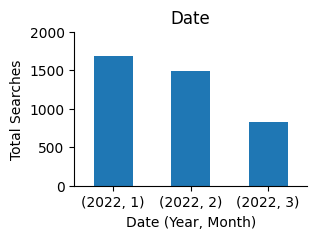

In [33]:
# Plot histogram of date feature
plt.figure(figsize=(3,2))
plt.title('Date')
new_df['Date'].groupby([new_df["Date"].dt.year, new_df["Date"].dt.month]).count().plot(kind="bar",rot=0)
plt.xlabel('Date (Year, Month)')
plt.ylabel('Total Searches')
plt.ylim(0,2000)
sns.despine()

In [55]:
new_df['Date'].groupby([new_df["Date"].dt.year, new_df["Date"].dt.month]).count()

Date  Date
2022  1       1687
      2       1487
      3        825
Name: Date, dtype: int64

#### Part of a Policing Operation

In [34]:
# check whether the search opperation was part of a policing operation or not 
new_df['Part of a policing operation'].value_counts(dropna=False)

False    2240
NaN      1309
True      450
Name: Part of a policing operation, dtype: int64

In [35]:
# check whether the search opperation was part of a policing operation or not (normalized)
new_df['Part of a policing operation'].value_counts(dropna=False,normalize=True)

False    0.560140
NaN      0.327332
True     0.112528
Name: Part of a policing operation, dtype: float64

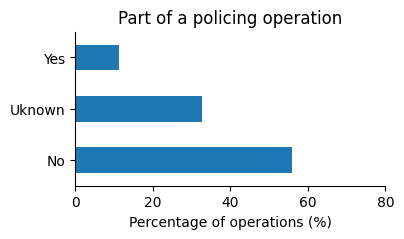

In [36]:
# Plot a bar-plot of "Part of a Policing Operation" feature
plt.figure(figsize=(4,2))
plt.title('Part of a policing operation')
plt.xlabel('Percentage of operations (%)')
new_df['Part of a policing operation'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.xticks([0,0.2,0.4,0.6,0.8],['0','20','40','60','80'])
plt.yticks([0,1,2],['No','Uknown', 'Yes'])
sns.despine()

#### Gender

In [37]:
# check the gender of the target of the search opperation
new_df['Gender'].value_counts(dropna=False)

Male      3506
Female     467
Other       26
Name: Gender, dtype: int64

In [38]:
# check the gender of the target of the search opperation (normalized)
new_df['Gender'].value_counts(dropna=False,normalize=True)

Male      0.876719
Female    0.116779
Other     0.006502
Name: Gender, dtype: float64

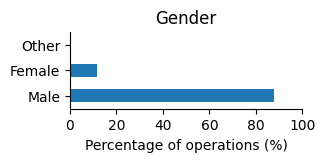

In [39]:
# Plot a bar-plot of "Part of a Policing Operation" feature
plt.figure(figsize=(3,1))
plt.title('Gender')
plt.xlabel('Percentage of operations (%)')
new_df['Gender'].value_counts(normalize=True,dropna=False).plot(kind='barh',rot=0)
plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
sns.despine()

#### Age

In [40]:
# check the age of the target of the search opperation
new_df['Age range'].value_counts(dropna=False)

over 34     1185
18-24       1143
25-34       1028
10-17        635
under 10       8
Name: Age range, dtype: int64

In [41]:
# check the age of the target of the search opperation (normalized)
new_df['Age range'].value_counts(dropna=False,normalize=True)

over 34     0.296324
18-24       0.285821
25-34       0.257064
10-17       0.158790
under 10    0.002001
Name: Age range, dtype: float64

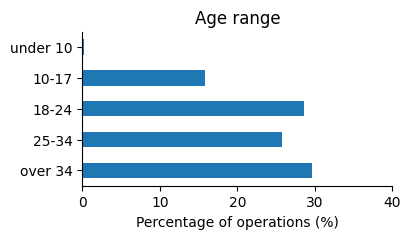

In [42]:
# list with order of ages
order = ["over 34","25-34","18-24","10-17","under 10"]

# plot histogram with distribuition of ages in dataset
plt.figure(figsize=(4,2))
plt.title('Age range')
plt.xlabel('Percentage of operations (%)')
new_df['Age range'].value_counts(normalize=True,dropna=False).reindex(order).plot(kind='barh')
plt.xticks([0,0.1,0.2,0.3,0.4],['0','10','20','30','40'])
sns.despine()

#### Self-defined ethnicity

In [43]:
# check the officer-defined ethinicity of the target of the search opperation
new_df['Officer-defined ethnicity'].value_counts(dropna=False)

White    2992
Black     465
Asian     399
Other      86
Mixed      57
Name: Officer-defined ethnicity, dtype: int64

In [44]:
# check the officer-defined ethinicity of the target of the search opperation (normalized)
new_df['Officer-defined ethnicity'].value_counts(dropna=False,normalize=True)

White    0.748187
Black    0.116279
Asian    0.099775
Other    0.021505
Mixed    0.014254
Name: Officer-defined ethnicity, dtype: float64

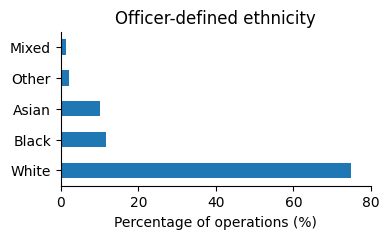

In [45]:
# plot histogram with distribuition of officer-defined ethnicities in dataset
plt.figure(figsize=(4,2))
plt.title('Officer-defined ethnicity')
plt.xlabel('Percentage of operations (%)')
new_df['Officer-defined ethnicity'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.xticks([0,0.2,0.4,0.6,0.8],['0','20','40','60','80'])
sns.despine()

#### Legislation

In [46]:
# check the legislation under which the search opperation was conducted
new_df['Legislation'].value_counts(dropna=False)

Misuse of Drugs Act 1971 (section 23)                      2778
Police and Criminal Evidence Act 1984 (section 1)          1174
Criminal Justice Act 1988 (section 139B)                     26
Criminal Justice and Public Order Act 1994 (section 60)       8
Firearms Act 1968 (section 47)                                7
Poaching Prevention Act 1862 (section 2)                      5
Psychoactive Substances Act 2016 (s36(2))                     1
Name: Legislation, dtype: int64

In [56]:
# check the legislation under which the search opperation was conducted
new_df['Legislation'].value_counts(dropna=False, normalize=True) * 100

Misuse of Drugs Act 1971 (section 23)                      69.467367
Police and Criminal Evidence Act 1984 (section 1)          29.357339
Criminal Justice Act 1988 (section 139B)                    0.650163
Criminal Justice and Public Order Act 1994 (section 60)     0.200050
Firearms Act 1968 (section 47)                              0.175044
Poaching Prevention Act 1862 (section 2)                    0.125031
Psychoactive Substances Act 2016 (s36(2))                   0.025006
Name: Legislation, dtype: float64

In [47]:
new_df['Legislation'].nunique()

7

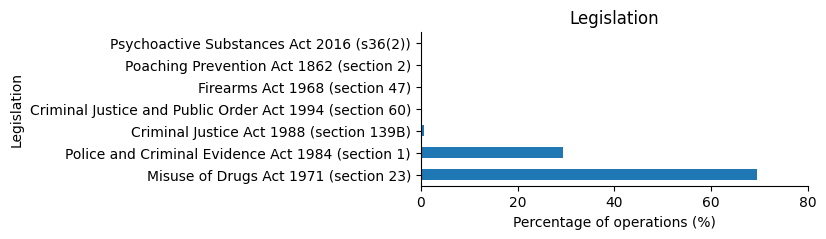

In [48]:
# plot a histogram of all legislations
plt.figure(figsize=(5,2))
plt.title('Legislation')
new_df['Legislation'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.ylabel('Legislation')
plt.xlabel('Percentage of operations (%)')
plt.xticks([0,0.2,0.4,0.6,0.8],["0","20","40","60","80"])
sns.despine()

#### Object of Search

In [49]:
# check the "reason"/object of the search opperation was conducted
new_df['Object of search'].value_counts(dropna=False)

Controlled drugs                       2783
Offensive weapons                       500
Article for use in theft                399
Stolen goods                            262
Articles for use in criminal damage      26
Firearms                                 10
Fireworks                                 8
Game or poaching equipment                5
Evidence of offences under the Act        5
Psychoactive substances                   1
Name: Object of search, dtype: int64

In [50]:
# check the "reason"/object of the search opperation was conducted (normalized)
new_df['Object of search'].value_counts(dropna=False, normalize=True) * 100

Controlled drugs                       69.592398
Offensive weapons                      12.503126
Article for use in theft                9.977494
Stolen goods                            6.551638
Articles for use in criminal damage     0.650163
Firearms                                0.250063
Fireworks                               0.200050
Game or poaching equipment              0.125031
Evidence of offences under the Act      0.125031
Psychoactive substances                 0.025006
Name: Object of search, dtype: float64

In [57]:
new_df['Object of search'].nunique()

10

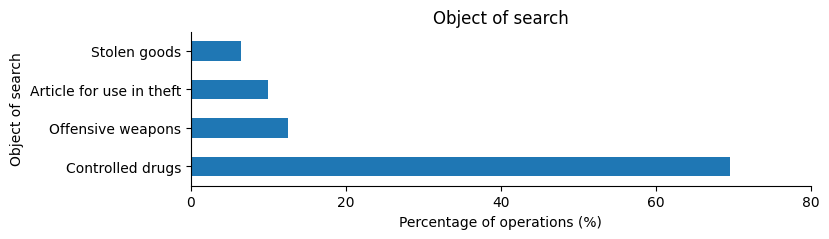

In [51]:
# plot a histogram of main "object of search" category
plt.figure(figsize=(8,2))
plt.title('Object of search')
new_df['Object of search'].value_counts(normalize=True,dropna=False).plot(kind='barh')
plt.ylabel('Object of search')
plt.xlabel('Percentage of operations (%)')
plt.xticks([0,0.2,0.4,0.6,0.8],["0","20","40","60","80"])
plt.ylim(-0.5,3.5)
sns.despine()

#### Police station

In [52]:
# check the outcome of the search opperation
new_df['station'].value_counts(dropna=False)

devon-and-cornwall    1090
bedfordshire           827
nottinghamshire        758
city-of-london         473
cambridgeshire         430
durham                 421
Name: station, dtype: int64

In [53]:
# Check the station which conducted the search opperation
new_df['station'].value_counts(dropna=False, normalize=True)*100

devon-and-cornwall    27.256814
bedfordshire          20.680170
nottinghamshire       18.954739
city-of-london        11.827957
cambridgeshire        10.752688
durham                10.527632
Name: station, dtype: float64

In [54]:
new_df['station'].nunique()

6

#### Predicted Successful Searches

In [39]:
new_df['pred'].value_counts(dropna=False,normalize=True)*100

True     50.162541
False    49.837459
Name: pred, dtype: float64

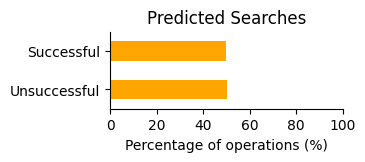

In [70]:
plt.figure(figsize=(3,1))
plt.title('Predicted Searches')
plt.xlabel('Percentage of operations (%)')
new_df['pred'].fillna(False).value_counts(normalize=True,dropna=False).plot(kind='barh',rot=0, color='orange')
plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
plt.yticks([0,1],['Unsuccessful','Successful'])
sns.despine()

#### Successful Searches

In [41]:
new_df['true_class'].value_counts(dropna=False,normalize=True)*100

0.0    78.144536
1.0    21.855464
Name: true_class, dtype: float64

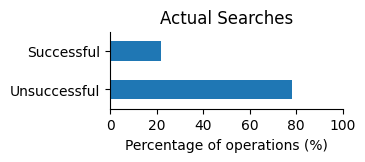

In [69]:
plt.figure(figsize=(3,1))
plt.title('Actual Searches')
plt.xlabel('Percentage of operations (%)')
new_df['true_class'].fillna(False).value_counts(normalize=True,dropna=False).plot(kind='barh',rot=0)
plt.xticks([0,0.2,0.4,0.6,0.8,1],['0','20','40','60','80','100'])
plt.yticks([0,1],['Unsuccessful','Successful'])
sns.despine()

In [43]:
new_df.groupby(['station']).count()['true_class']

station
bedfordshire           827
cambridgeshire         430
city-of-london         473
devon-and-cornwall    1090
durham                 421
nottinghamshire        758
Name: true_class, dtype: int64

In [44]:
new_df[new_df['true_class']==0].groupby(['station']).count()['true_class']

station
bedfordshire          653
cambridgeshire        314
city-of-london        367
devon-and-cornwall    896
durham                310
nottinghamshire       585
Name: true_class, dtype: int64

In [45]:
new_df[new_df['true_class']==1].groupby(['station']).count()['true_class']

station
bedfordshire          174
cambridgeshire        116
city-of-london        106
devon-and-cornwall    194
durham                111
nottinghamshire       173
Name: true_class, dtype: int64

In [46]:
counts_by_station = new_df.groupby('station')['true_class'].value_counts(normalize=True)*100
counts_by_station

station             true_class
bedfordshire        0.0           78.960097
                    1.0           21.039903
cambridgeshire      0.0           73.023256
                    1.0           26.976744
city-of-london      0.0           77.589852
                    1.0           22.410148
devon-and-cornwall  0.0           82.201835
                    1.0           17.798165
durham              0.0           73.634204
                    1.0           26.365796
nottinghamshire     0.0           77.176781
                    1.0           22.823219
Name: true_class, dtype: float64

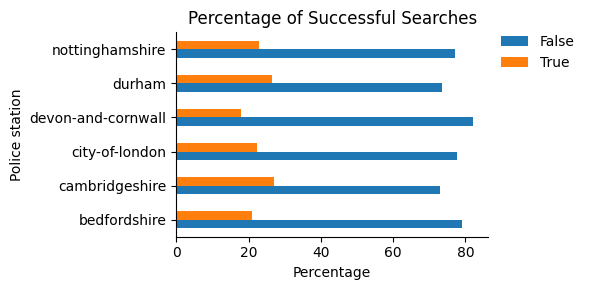

In [47]:
counts_by_station.unstack().plot.barh(rot=0, width=0.5,figsize=(6,3))
plt.ylabel('Police station')
plt.xlabel('Percentage')
plt.title('Percentage of Successful Searches')
plt.legend(labels=['False', 'True'],frameon=False, ncol=1, bbox_to_anchor=(1, 1.05))
sns.despine()
plt.tight_layout()

### EVALUATION ON DISCRIMINATION REQUIREMENTS

In [48]:
def verify_no_discrimination_stations(X_test, y_true, y_pred, sensitive_column, max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination between "sensitive_column" categories
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_departments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_departments

In [50]:
new_df.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,proba,pred,true_class
0,Person and Vehicle search,2022-01-01 03:08:37+00:00,NaN,52.312706,-0.225271,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire,0.715158,True,1.0
1,Person search,2022-01-01 04:29:00+00:00,True,50.625847,-3.546839,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.446089,False,0.0
2,Person search,2022-01-01 05:50:23+00:00,NaN,51.518091,-0.078308,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.127540,False,0.0
3,Person search,2022-01-01 07:34:03+00:00,NaN,51.506255,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.173887,False,0.0
4,Person search,2022-01-01 16:43:00+00:00,False,50.725010,-3.524855,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0.462372,False,1.0


In [58]:
# Split the data into features and target
X_test = new_df
y_test = new_df['true_class']
y_preds = new_df['pred']

In [59]:
def verify_no_discrimination_stations(X_test, y_true, y_pred, sensitive_column, max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination between "sensitive_column" categories
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_departments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_departments

In [64]:
# Evaluate the model success between (officer-defined) ethnicities
print("Officer-defined ethnicity:\n")

is_satisfied, problematic_departments, good_departments = verify_no_discrimination_stations(
    X_test, y_test, preds, sensitive_column='Officer-defined ethnicity',max_diff=0.05)


if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_departments)))
    print ('\n')
    print ("Problematic departments:",[i[0] for i in problematic_departments])
    print ('\n')
    print ("Good departments:",[i[0] for i in good_departments])
    print ('\n')
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))

print("Departments analysed: {}".format(len(problematic_departments) + len(good_departments)))

Officer-defined ethnicity:

Requirement failed 😢
Num problematic departments: 6
Num good departments: 0


Problematic departments: ['cambridgeshire', 'devon-and-cornwall', 'city-of-london', 'bedfordshire', 'durham', 'nottinghamshire']


Good departments: []


avg diff: 0.3820252701633342
Departments analysed: 6


In [61]:
def verify_no_discrimination_object_of_search(X_test, y_true, y_pred, sensitive_column, max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination between "sensitive_column" categories
    
    """
    
    departments = X_test['Object of search'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['Object of search'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments

In [62]:
# Evaluate the model success between "object of search" categories
print("Object of search:\n")

is_satisfied, problematic_searches, good_searches = verify_no_discrimination_object_of_search(
    X_test, y_test, preds, sensitive_column='Officer-defined ethnicity',max_diff=0.05)


if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic search categories: {}".format(len(problematic_searches)))
    print("Num good search cateogories: {}".format(len(good_searches)))
    print ('\n')
    print ("Problematic search categories:",[i[0] for i in problematic_searches])
    print ('\n')
    print ("Good search categories:",[i[0] for i in good_searches])
    print ('\n')
    print("avg diff:", np.mean([p[1] for p in problematic_searches]))

    
print("Objects of search categories analysed: {}".format(len(problematic_searches) + len(good_searches)))

Object of search:

Requirement failed 😢
Num problematic search categories: 4
Num good search cateogories: 6


Problematic search categories: ['Controlled drugs', 'Offensive weapons', 'Article for use in theft', 'Stolen goods']


Good search categories: ['Game or poaching equipment', 'Firearms', 'Articles for use in criminal damage', 'Fireworks', 'Psychoactive substances', 'Evidence of offences under the Act']


avg diff: 0.34580570291777185
Objects of search categories analysed: 10
